In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools

### read glodap data

In [2]:
glodap = {}
for f in ['BkgC14','CFC11','pCFC11','CFC12','pCFC12','BombC14','C14']:
    glodapi = xr.open_dataset('/glade/p/work/mclong/GLODAP/GLODAP_orig/%s.nc'%f)
    glodapi = glodapi.transpose('depth','latitude','longitude')    
    if glodap:
        glodap = xr.merge((glodap,glodapi))
    else:
        glodap = glodapi
        
glodap = glodap.rename({'latitude':'lat','longitude':'lon'})
glodap

<xarray.Dataset>
Dimensions:     (depth: 33, lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * depth       (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 ...
Data variables:
    BkgC14      (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    BkgC14Err   (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    dz          (depth) float64 5.0 10.0 10.0 15.0 20.0 25.0 25.0 25.0 40.0 ...
    CFC11       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC11Err    (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    pCFC11      (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    pCFC11Err   (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC12       (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    CFC12Err    (depth, lat, lon) float64 nan nan n

### read woa data

In [3]:
woapth = '/glade/p/ncgd0033/obs/woa2013v2/1x1d'

woa_info = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t01_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s01_01v2.nc')}}

woa = {}
for v,info in woa_info.items():   
    varname = info['varname']
    file_in = info['file']
    woai = xr.open_dataset(file_in,decode_times=False)
    woai = woai.drop([k for k in woai if k not in [varname,'lat','lon','depth']])
    woai = woai.rename({varname:v})
    if woa:
        woa = xr.merge((woa,woai))
    else:
        woa = woai
         
ni = len(woa.lon)
nj = len(woa.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    woa[v] = woa[v] * mlperl_2_mmolm3
    woa[v].attrs['units'] = 'mmol m$^{-3}$'
woa

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: time
Data variables:
    O2sat    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

### compute thermocline mean: 200-600 m

In [4]:
glodap_tc = glodap.sel(depth=slice(200.,600.)).mean(dim='depth')
glodap_tc

<xarray.Dataset>
Dimensions:     (lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
Data variables:
    BkgC14      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    BkgC14Err   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    dz          float64 79.17
    CFC11       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    CFC11Err    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    pCFC11      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    pCFC11Err   (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    CFC12       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    CFC12Err    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    pCFC12      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    pCFC12Err   (lat, lo

In [5]:
woa_tc = woa.sel(depth=slice(200.,600.)).mean(dim='depth').isel(time=0)
woa_tc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    O2sat    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    AOU      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    S        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    T        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...

### make the plot

initial plot size (display units): 6.98,3.54
Adjusting fig size:
	(W,H in): 10.00,4.00 --> 8.03,6.73
new plot size: 5.61,3.57


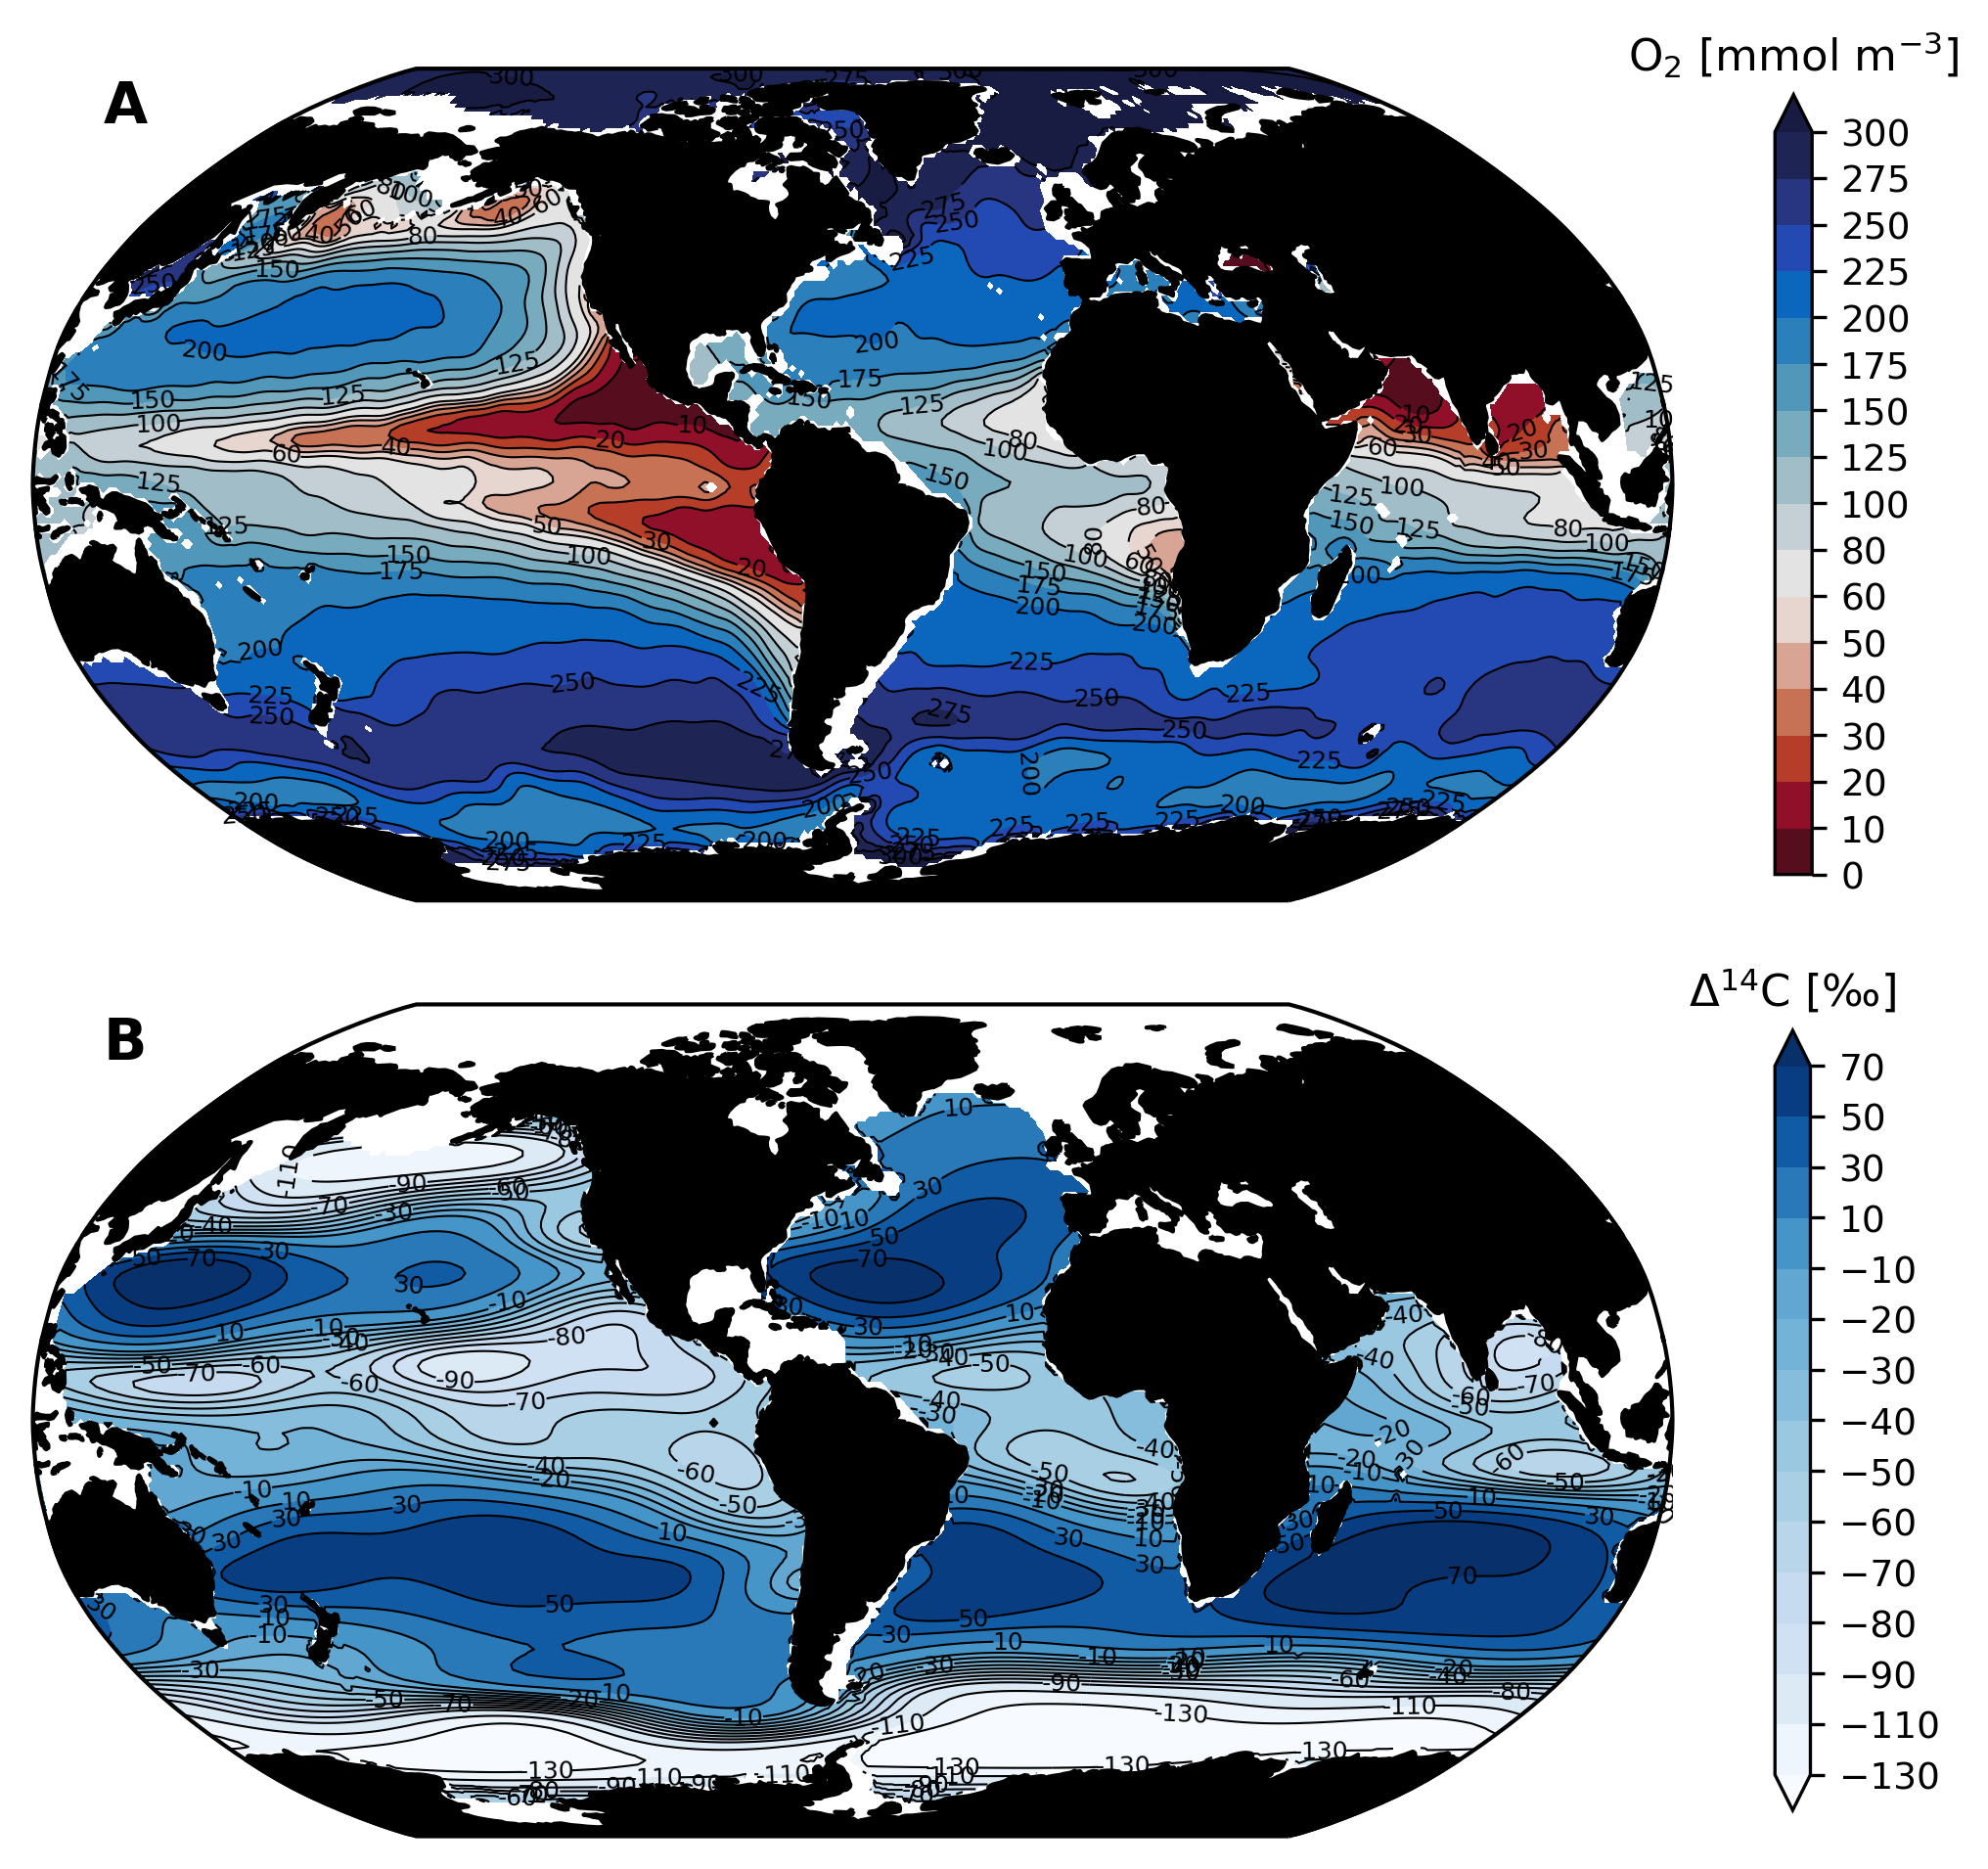

In [6]:
plot_name = os.path.join(diro['fig'],'woa-thermocline-o2-w-age_metric.pdf')

norm_o2 = plot_tools.MidPointNorm(midpoint=60.) 
norm_cfc = plot_tools.MidPointNorm(midpoint=30.) 
norm_c14 = plot_tools.MidPointNorm(midpoint=-20.) 
plots = {'O2' : 
         {'ds':woa_tc,
          'units' : 'O$_2$ [mmol m$^{-3}$]',
           'contour_specs': {'levels':[0,10,20,30,40,50,60,80,100,125,150,175,200,225,250,275,300],
                            'cmap':cmocean.cm.balance_r,
                            'norm':norm_o2,'extend':'max'}},
        'pCFC11' :
         {'ds':glodap_tc,
          'units' : 'pCFC-11 [patm]',
           'contour_specs': {'levels':[0.,10.,20.,30.,40.,50.,60.,80.,100.,125.,150.,175.,200.,225.],
                            'cmap':'Blues',
                            'norm':norm_o2,'extend':'max'}},
        'C14' :
         {'ds':glodap_tc,
          'units' : '$\Delta^{14}C$ ['+u'\u2030'+']',
           'contour_specs': {'levels':[-130,-110,-90,-80,-70,-60,-50,-40,-30,-20,-10,10,30,50,70],
                            'cmap':'Blues',
                            'norm':norm_c14,'extend':'both'}}}         

del plots['pCFC11']

matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'

fig=plt.figure(figsize=(10, 4),dpi=300)
gs = gridspec.GridSpec(2,1)
       
obj = {}
ax = []
for i,(v,specs) in enumerate(plots.items()):
    ds_tc = specs['ds']
    units = specs['units']         
    contour_specs = specs['contour_specs']
          
    lat = ds_tc.lat.values
    lon = ds_tc.lon.values
    z = ds_tc[v].values

    lon = np.where(lon<0.,lon+360.,lon)
    I = np.argsort(lon)
    lon = lon[I]
    z = z[:,I]
    z,lon = add_cyclic_point(z,coord=lon)   

    obj[v] = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                                   contour_specs,
                                                   units = units,
                                                   fig=fig,
                                                   gridspec=gs,
                                                   row=i,col=0)
    ax.append(obj[v]['ax'])

gridspec_kwargs = {'hspace' : -0.1,
                   'wspace' : 0.05,
                   'left' : 0.,
                   'right' : 0.87,
                   'bottom' : 0.,
                   'top' : 1.}
fgsz = plot_tools.plotgrid(fig, gs, ax, [2,1],gridspec_kwargs)

alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1-0.08
    fig.text(0.03,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
plt.savefig(plot_name,dpi=300,bbox_inches='tight')
          